In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import  Model, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, SimpleRNN, GRU, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from keras.utils import to_categorical
import seaborn as sns
from tensorflow.keras.optimizers import Adam

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('/content/combined_emotion.csv')

In [ ]:
data.shape

(232782, 2)

In [ ]:
data.columns

Index(['sentence', 'emotion'], dtype='object')

In [ ]:
data.head()

,sentence,emotion
0,i just feel really helpless and heavy hearted,fear
1,ive enjoyed being able to slouch about relax a...,sad
2,i gave up my internship with the dmrg and am f...,fear
3,i dont know i feel so lost,sad
4,i am a kindergarten teacher and i am thoroughl...,fear


In [ ]:
data.sample(5)

,sentence,emotion
156160,i don t feel others should be undervalued peop...,joy
165854,i feel like my house is still cute,joy
315,i still feel unsure sometimes,fear
195051,i feel should be valued by me,joy
175659,i feel hopeful that the wounds will heal but i...,joy


In [ ]:
data

,sentence,emotion
0,i just feel really helpless and heavy hearted,fear
1,ive enjoyed being able to slouch about relax a...,sad
2,i gave up my internship with the dmrg and am f...,fear
3,i dont know i feel so lost,sad
4,i am a kindergarten teacher and i am thoroughl...,fear
...,...,...
232777,im feeling nostalgic and think my brothers are...,love
232778,i am aware that this could lead to all types o...,joy
232779,i feel reluctant to forgive and forget sometim...,fear
232780,i am feeling adventurous ill go with one of th...,joy


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232782 entries, 0 to 232781
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   sentence  232782 non-null  object
 1   emotion   232781 non-null  object
dtypes: object(2)
memory usage: 3.6+ MB


In [ ]:
data.isnull().sum()

,0
sentence,0
emotion,1


In [ ]:
data.describe()

,sentence,emotion
count,232782,232781
unique,225587,6
top,i feel more adventurous willing to take risks ...,joy
freq,8,78699


In [ ]:
data.drop_duplicates(inplace=True)

In [ ]:
data.sample(5)

,sentence,emotion
105826,i feel safe beautiful and appreciated,joy
32352,i feel i am perpetually confused,fear
41954,i feel that she may have been suspicious,fear
18860,i understand that a lot of things are out of y...,sad
137511,i was feeling apprehensive and nervous,fear


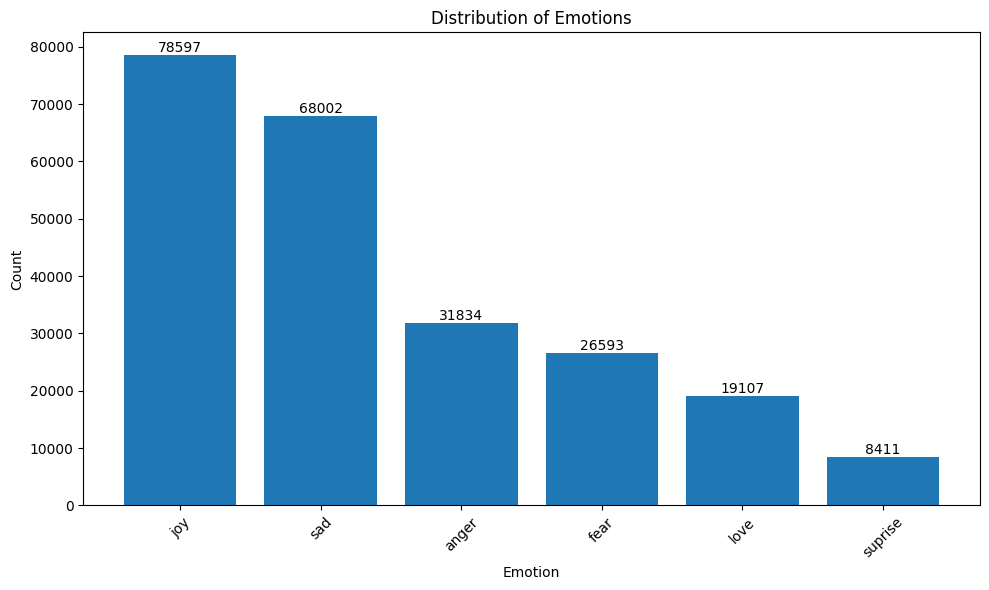


Total number of emotion classes: 6


In [ ]:
# Get emotion counts
emotion_counts = data['emotion'].value_counts()

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(emotion_counts.index, emotion_counts.values)
plt.title('Distribution of Emotions')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Add value labels on top of each bar
for i, v in enumerate(emotion_counts.values):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print total number of classes
print(f"\nTotal number of emotion classes: {len(emotion_counts)}")

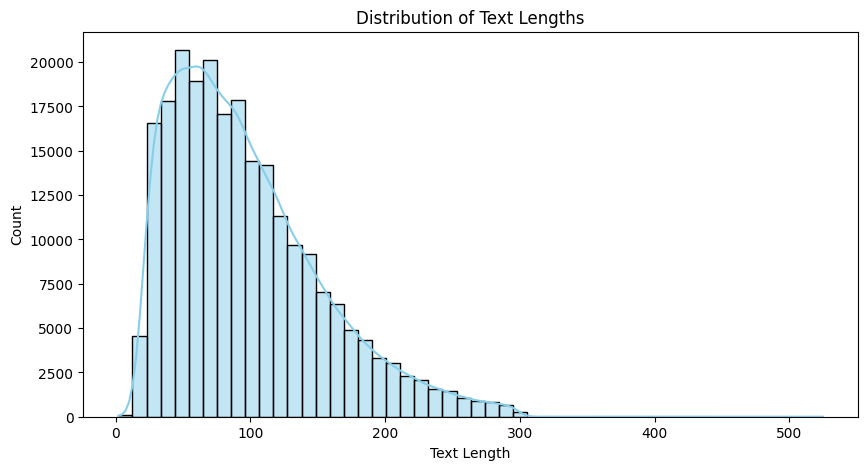

In [ ]:
# Add a column for text length
data['text_length'] = data['sentence'].apply(len) # Changed 'text' to 'sentence'

plt.figure(figsize=(10,5))
sns.histplot(data['text_length'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of Text Lengths")
plt.xlabel("Text Length")
plt.show()

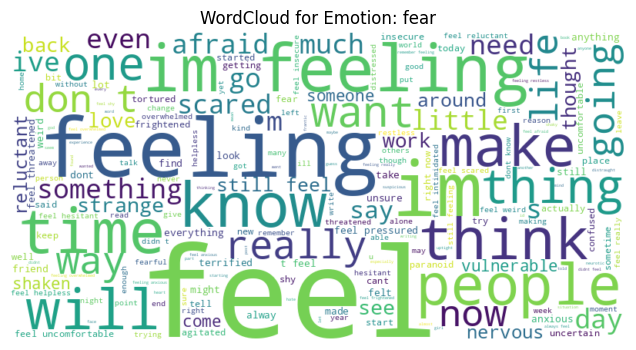

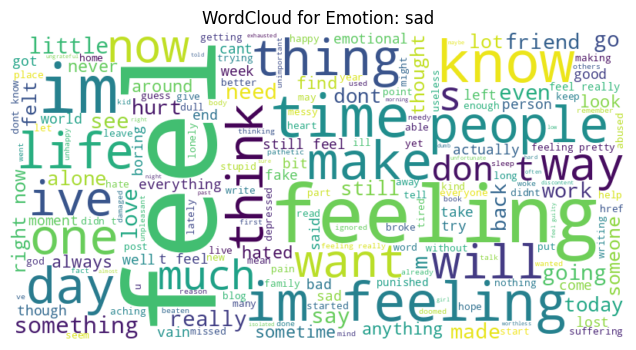

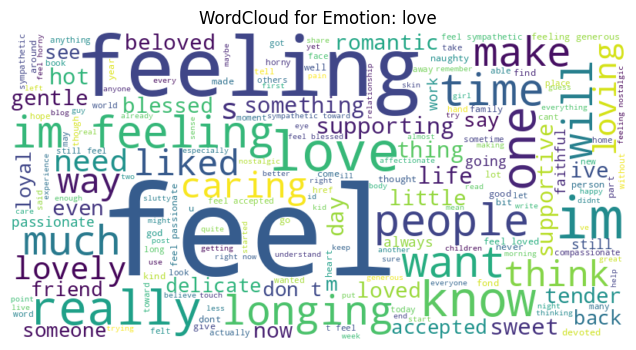

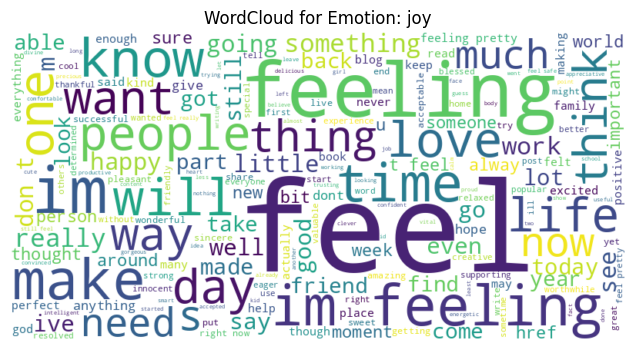

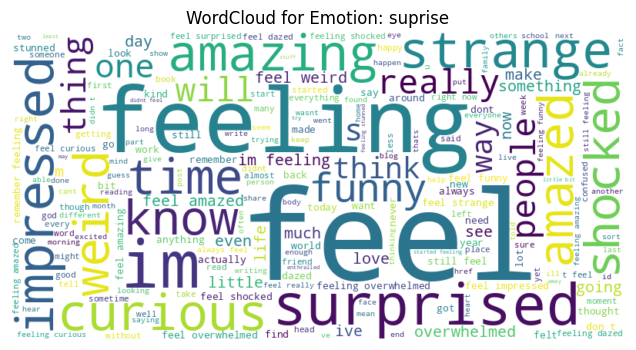

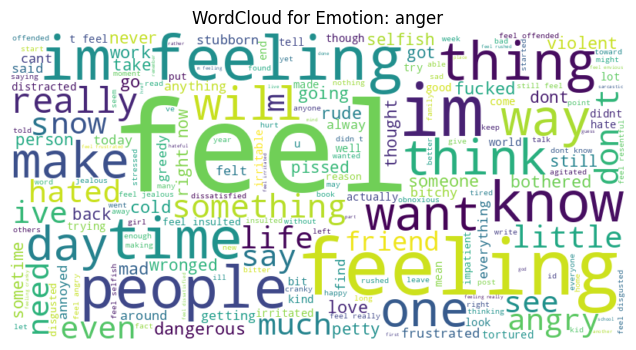

No text found for emotion: nan. Skipping wordcloud generation.


<Figure size 800x400 with 0 Axes>

In [ ]:
from wordcloud import WordCloud

emotions = data['emotion'].unique()

for emo in emotions:
    plt.figure(figsize=(8,4))
    subset = data[data['emotion'] == emo]
    # Changed 'text' to 'sentence' to match the actual column name
    text = " ".join(subset['sentence'])

    # Check if text is empty before generating wordcloud
    if len(text) > 0:  # Or: if text:
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"WordCloud for Emotion: {emo}")
        plt.show()
    else:
        print(f"No text found for emotion: {emo}. Skipping wordcloud generation.")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


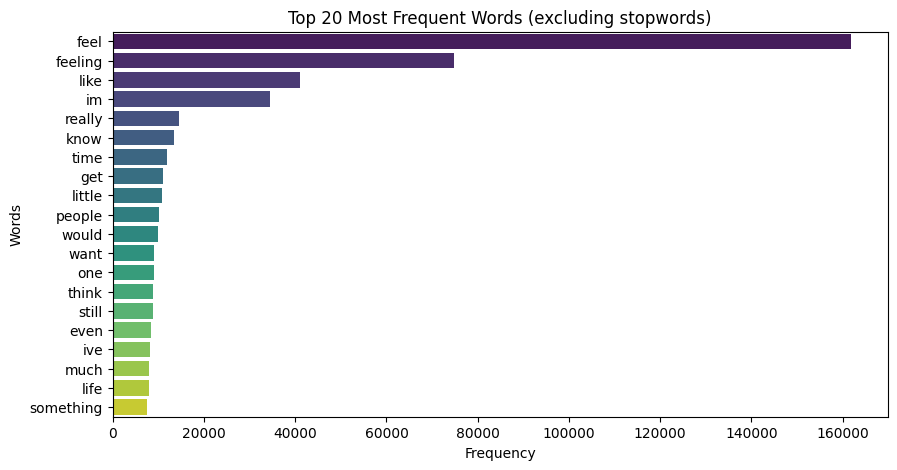

In [ ]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Replace 'text' with 'sentence' to access the correct column in the DataFrame
all_words = ' '.join(data['sentence']).lower().split()
filtered_words = [word for word in all_words if word not in stop_words]
common_words = Counter(filtered_words).most_common(20)

words, counts = zip(*common_words)
plt.figure(figsize=(10,5))
sns.barplot(x=list(counts), y=list(words), palette='viridis')
plt.title("Top 20 Most Frequent Words (excluding stopwords)")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

In [ ]:
# Convert emotion labels to strings explicitly
classes = data['emotion'].astype(str).unique()

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=data['emotion'].astype(str)  # Convert y to string as well
)

# Create dictionary mapping classes to weights
class_weight_dict = dict(zip(classes, class_weights))

print("\nClass weights:")
for emotion, weight in class_weight_dict.items():
    print(f"{emotion}: {weight:.4f}")


Class weights:
fear: 1.2492
sad: 0.4885
love: 1.7387
joy: 0.4227
suprise: 3.9497
anger: 1.0436
nan: 33220.7143


In [ ]:
classes = data['emotion'].unique()

classes

array(['fear', 'sad', 'love', 'joy', 'suprise', 'anger', nan],
      dtype=object)

In [ ]:
# Get unique words (actual vocabulary size)
unique_words = set(' '.join(data['sentence']).lower().split())
vocab_size = len(unique_words)
print(f"Actual vocabulary size (unique words): {vocab_size}")

# Total words (including repetitions)
total_words = len(' '.join(data['sentence']).split())
print(f"Total number of words in the data: {total_words}")

Actual vocabulary size (unique words): 57395
Total number of words in the data: 4468683


In [ ]:

data.dropna(subset=['emotion'], inplace=True)


# Now proceed with train_test_split
X = data['sentence']
y = data['emotion']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [ ]:
num_words = 50000
embedding_dim = 100
max_length = 100

In [ ]:
# get maximum length of the data text for padding
max_length = min(max([len(x.split()) for x in X]), max_length)
print(f"Maximum length of the data text: {max_length}")

Maximum length of the data text: 100


In [ ]:
# Create tokenizer
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

# Get vocabulary size from tokenizer
vocab_size =  min(len(tokenizer.word_index) + 1, num_words)    # +1 for padding token (0)
print(f"Tokenizer vocabulary size: {vocab_size}")

Tokenizer vocabulary size: 50000


In [ ]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')

In [ ]:
# Label encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# One-hot encode the labels
y_onehot = to_categorical(y_encoded)

# Split into train/test
_, _, y_train, y_test = train_test_split(
    X, y_onehot,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [ ]:
y_train, y_test

(array([[0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        ...,
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.]]),
 array([[0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        ...,
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.]]))

In [ ]:
X_train, y_train

(array([[  1, 330,  10, ...,   0,   0,   0],
        [  1,   2,  37, ...,   0,   0,   0],
        [  1,  42,   8, ...,   0,   0,   0],
        ...,
        [  1,   2,  37, ...,   0,   0,   0],
        [  1,   2,  14, ...,   0,   0,   0],
        [  1,   2,  13, ...,   0,   0,   0]], dtype=int32),
 array([[0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        ...,
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.]]))

In [ ]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (186035, 100)
X_test shape: (46509, 100)
y_train shape: (186035, 6)
y_test shape: (46509, 6)


In [ ]:
# Print 5 sample sentences with their details
print("Sample sentences with details:\n")
for i in range(5):
    # Get original text
    sentence = X[i]
    # Get encoded sequence
    encoded_seq = X_train[i]
    # Get emotion label (from one-hot to label)
    emotion_idx = np.argmax(y_train[i])
    emotion = label_encoder.inverse_transform([emotion_idx])[0]

    print(f"Sample {i+1}:")
    print(f"Text: {sentence}")
    print(f"Encoded sequence: {encoded_seq[:10]}...")  # Show first 10 tokens
    print(f"Emotion: {emotion}")
    print(f"One-hot encoded emotion: {y_train[i]}")
    print("-" * 80)

Sample sentences with details:

Sample 1:
Text: i just feel really helpless and heavy hearted
Encoded sequence: [    1   330    10   892    20   147 12097     9     5    84]...
Emotion: joy
One-hot encoded emotion: [0. 0. 1. 0. 0. 0.]
--------------------------------------------------------------------------------
Sample 2:
Text: ive enjoyed being able to slouch about relax and unwind and frankly needed it after those last few weeks around the end of uni and the expo i have lately started to find myself feeling a bit listless which is never really a good thing
Encoded sequence: [  1   2  37 679   4 300   0   0   0   0]...
Emotion: fear
One-hot encoded emotion: [0. 1. 0. 0. 0. 0.]
--------------------------------------------------------------------------------
Sample 3:
Text: i gave up my internship with the dmrg and am feeling distraught
Encoded sequence: [  1  42   8  81  56  26 160   8   1  23]...
Emotion: sad
One-hot encoded emotion: [0. 0. 0. 0. 1. 0.]
-----------------------------

In [ ]:
# Print 2 sample tokens and their embeddings
print("Sample tokens and their embeddings:\n")
for word in list(tokenizer.word_index.keys())[:2]:
    word_id = tokenizer.word_index[word]

    print(f"Token: {word}")
    print(f"Index in vocabulary: {word_id}")
    print("-" * 80)

Sample tokens and their embeddings:

Token: i
Index in vocabulary: 1
--------------------------------------------------------------------------------
Token: feel
Index in vocabulary: 2
--------------------------------------------------------------------------------


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

In [ ]:
# Model hyperparameters
NUM_EMOTION_CLASSES = 6
VALIDATION_SPLIT = 0.2
DROPOUT_RATE = 0.2
#VERBOSE = 0

In [ ]:
# Input layer for sequences
input = Input(shape=(max_length,))

# Embedding layer
x = Embedding(input_dim=vocab_size,
              output_dim=embedding_dim, input_length=max_length)(input)

# GRU layer
x = GRU(128, return_sequences=True)(x)
x = BatchNormalization()(x)

# Dropout for regularization
x = Dropout(0.3)(x)

# GRU layer
x = GRU(128, return_sequences=False)(x)
x = BatchNormalization()(x)

x = Dropout(0.3)(x)
# Dense layers
x = Dense(64, activation='relu')(x)
x = Dense(NUM_EMOTION_CLASSES, activation='softmax')(x)

# Create model
gru_model = Model(inputs=input, outputs=x)

# Compile model
gru_model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

gru_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 100)       │     5,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 100, 128)       │        88,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,197,062 (19.83 MB)

 Trainable params: 5,196,550 (19.82 MB)

 Non-trainable params: 512 (2.00 KB)

In [ ]:
# Train the model
history = gru_model.fit(
    X_train, y_train,
    batch_size=512,
    epochs=5,
    validation_split=VALIDATION_SPLIT,
    #verbose=VERBOSE,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/5
291/291 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.3069 - loss: 1.6504 - val_accuracy: 0.3372 - val_loss: 1.5824 - learning_rate: 0.0010
Epoch 2/5
291/291 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4168 - loss: 1.3833 - val_accuracy: 0.8346 - val_loss: 0.5968 - learning_rate: 0.0010
Epoch 3/5
291/291 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.9412 - loss: 0.1047 - val_accuracy: 0.9393 - val_loss: 0.1071 - learning_rate: 0.0010
Epoch 4/5
291/291 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.9433 - loss: 0.0909 - val_accuracy: 0.9376 - val_loss: 0.1084 - learning_rate: 0.0010
Epoch 5/5
291/291 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9493 - loss: 0.0831 - val_accuracy: 0.9370 - val_loss: 0.1303 - learning_rate: 0.0010


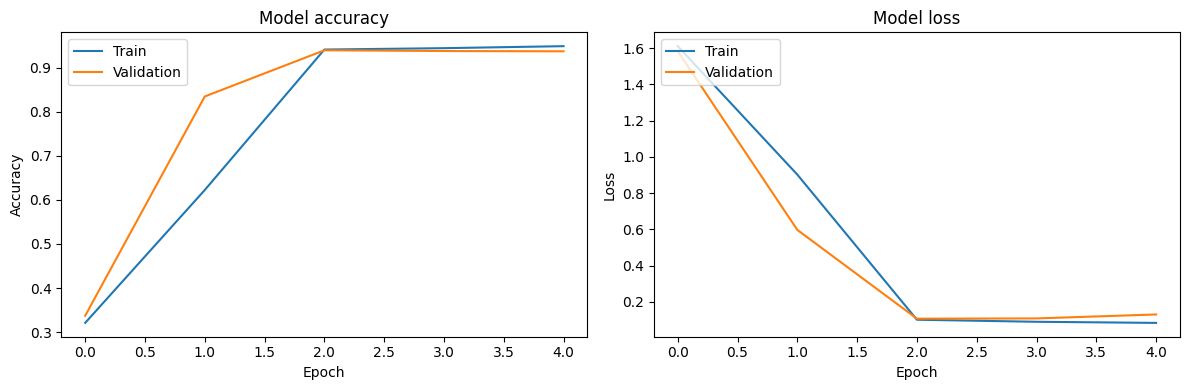

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


1454/1454 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step

Accuracy: 0.9388


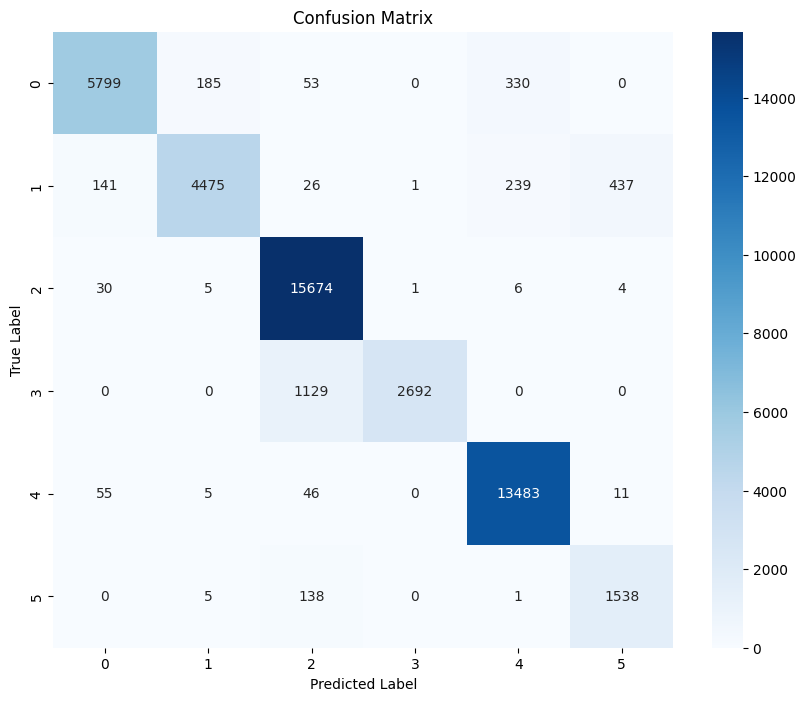

In [ ]:
# Get predictions on validation set
y_pred = gru_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calculate and print accuracy
accuracy = np.mean(y_pred_classes == y_test_classes)
print(f"\nAccuracy: {accuracy:.4f}")

# Create confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print cl

In [ ]:

# Print classification report
target_names = ['fear', 'sad', 'love', 'joy', 'suprise', 'anger'] # Based on the emotion labels seen in context
print('\nClassification Report:\n')
print(classification_report(y_test_classes, y_pred_classes, target_names=target_names))


Classification Report:

              precision    recall  f1-score   support

        fear       0.96      0.91      0.94      6367
         sad       0.96      0.84      0.90      5319
        love       0.92      1.00      0.96     15720
         joy       1.00      0.70      0.83      3821
     suprise       0.96      0.99      0.97     13600
       anger       0.77      0.91      0.84      1682

    accuracy                           0.94     46509
   macro avg       0.93      0.89      0.90     46509
weighted avg       0.94      0.94      0.94     46509



In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Z-test (example for comparing mean text length)

# Sample data
sample_mean = data['text_length'].mean()
population_mean = 50  # Hypothetical population mean
population_std = data['text_length'].std()
sample_size = len(data)

# Calculate z-statistic and p-value
# Changed 'alternative' to 'two-sided'
z_statistic, p_value = sm.stats.ztest(
    data['text_length'],
    value=population_mean,
    alternative='two-sided'
)

print(f"Z-test results (text length):\nZ-statistic: {z_statistic:.2f}\nP-value: {p_value:.3f}")


# ... (rest of the code remains the same)

# T-test (example for comparing text length between two emotions)

import statsmodels.api as sm
from statsmodels.formula.api import ols

# ... (other code) ...

# T-test (example for comparing text length between two emotions)

# Sample data for two emotions (e.g., 'joy' and 'sad')
joy_text_lengths = data[data['emotion'] == 'joy']['text_length']
# Corrected emotion label to 'sad' instead of 'sadness'
sad_text_lengths = data[data['emotion'] == 'sad']['text_length']

# Independent samples t-test
# Changed 'alternative' to 'two-sided'
t_statistic, p_value, _ = sm.stats.ttest_ind(
    joy_text_lengths, sad_text_lengths,
    alternative='two-sided'
)

print(f"\nIndependent samples t-test results (text length: joy vs. sad):\nT-statistic: {t_statistic:.2f}\nP-value: {p_value:.3f}")

# ... (rest of the code) ...


# ANOVA test (example for comparing text length across all emotions)

# Create a DataFrame for ANOVA
anova_data = data[['emotion', 'text_length']]

# Fit the ANOVA model
model = ols('text_length ~ emotion', data=anova_data).fit()
anova_table = sm.stats.anova_lm(model)

print(f"\nANOVA results (text length across emotions):\n{anova_table}")

Z-test results (text length):
Z-statistic: 404.00
P-value: 0.000

Independent samples t-test results (text length: joy vs. sad):
T-statistic: 18.39
P-value: 0.000

ANOVA results (text length across emotions):
                df        sum_sq        mean_sq           F         PR(>F)
emotion        5.0  2.474109e+06  494821.722088  157.475951  1.202341e-167
Residual  232538.0  7.306821e+08    3142.205016         NaN            NaN
